### FFC + CWT

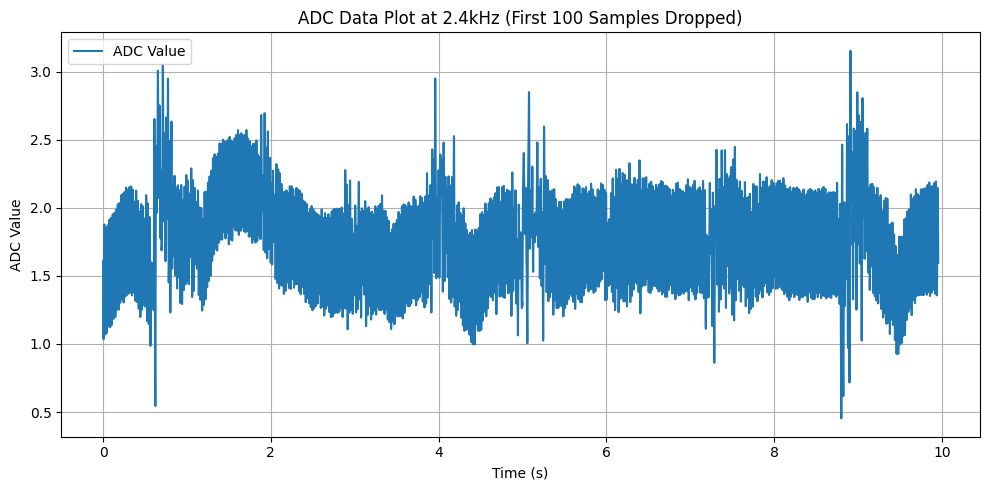

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
filename = 'full_movement_range_anterior_zginacze.csv'  # Use the full movement range file
sampling_rate = 2400  # in Hz
fs = sampling_rate

# Load ADC values (single column)
adc_values = pd.read_csv(filename, header=None).squeeze()  # Convert to Series

# Drop first 1000 samples
adc_values = adc_values[100:].reset_index(drop=True)
time = np.arange(len(adc_values)) / sampling_rate  # Recompute time axis

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, adc_values, label='ADC Value')
plt.xlabel('Time (s)')
plt.ylabel('ADC Value')
plt.title('ADC Data Plot at 2.4kHz (First 100 Samples Dropped)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

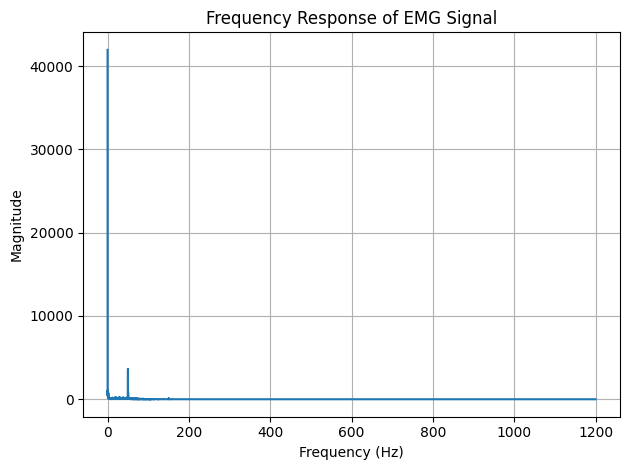

In [12]:
# FFT of the original signal
n = len(adc_values)
fft_signal = np.fft.fft(adc_values)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of EMG Signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

In [13]:
from scipy.signal import butter, filtfilt, iirnotch, hilbert, lfilter
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
import pywt

In [14]:
signal = adc_values
t = time
fs = sampling_rate

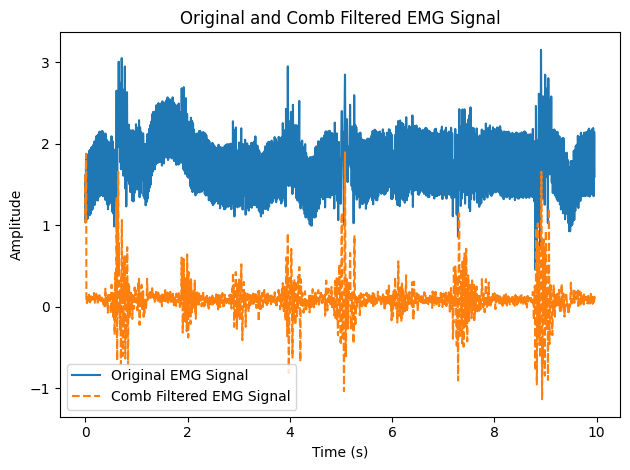

In [15]:
# Define the comb filter
def comb_filter(signal, delay, alpha):
    b = np.zeros(delay + 1)
    b[0] = 1
    b[-1] = -alpha
    a = [1]
    return lfilter(b, a, signal)

# Parameters for the comb filter
delay = int(fs / 50)  # Delay in samples (for 50 Hz)
alpha = 0.95  # Feedback coefficient

# Apply the comb filter to the signal
filtered_signal_FFC = comb_filter(signal, delay, alpha)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original EMG Signal')
ax.plot(t, filtered_signal_FFC, label='Comb Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Comb Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

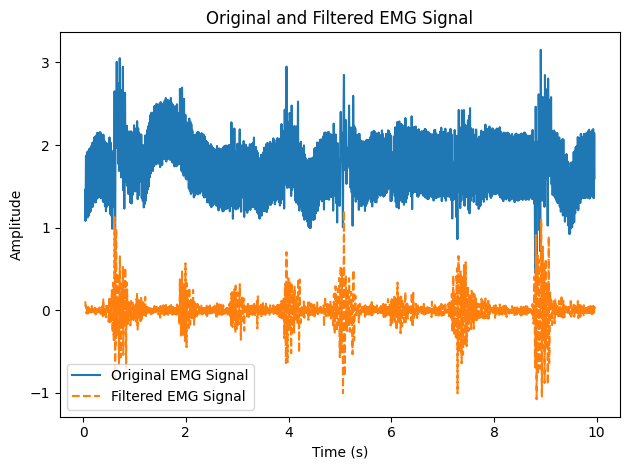

In [16]:
# Design the bandpass filter
lowcut = 20.0
highcut = 500.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, filtered_signal_FFC)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t[100:], signal[100:], label='Original EMG Signal')
ax.plot(t[100:], filtered_signal[100:], label='Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

signal = filtered_signal

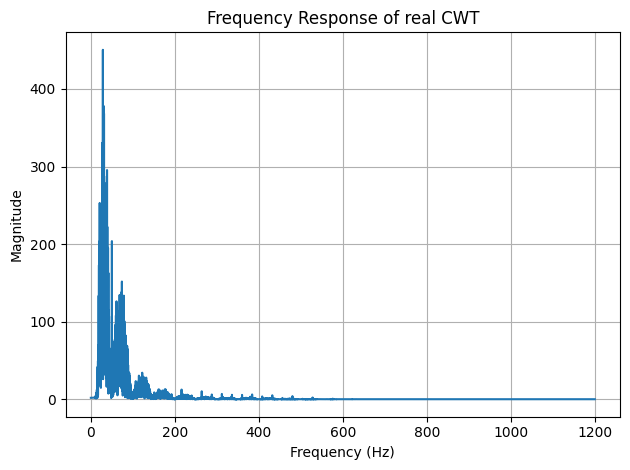

In [17]:
filtered_signal = filtered_signal[100:]  # Drop first 100 samples after filtering
t = np.arange(len(filtered_signal)) / fs  # Recompute time axis after filtering

# fft of the real cwt
n = len(filtered_signal)
fft_signal = np.fft.fft(filtered_signal)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of real CWT")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

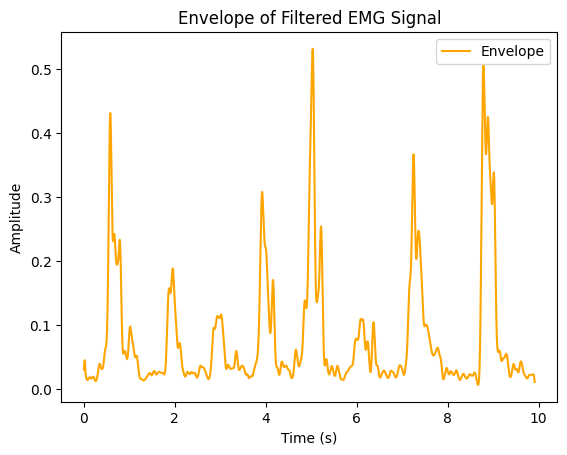

In [18]:
def linear_envelope(signal, fs, lowpass_cutoff=10.0, window_size=101):
    # Rectify
    rectified = np.abs(signal)
    # Low-pass filter
    nyquist = 0.5 * fs
    norm_cutoff = lowpass_cutoff / nyquist
    b, a = butter(2, norm_cutoff, btype='low')
    filtered = filtfilt(b, a, rectified)
    # Moving average smoothing
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(filtered, window, mode='same')
    return smoothed

envelope = linear_envelope(filtered_signal, fs)

# Plot the envelope

plt.plot(t, envelope, label='Envelope', color='orange')
plt.title("Envelope of Filtered EMG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()     
plt.show()

Section 1 (grip): 0.3s to 1.7s, samples: 3361
Section 2 (thumb): 1.71s to 2.6s, samples: 2137
Section 3 (index): 2.61s to 3.7s, samples: 2617
Section 4 (middle): 3.71s to 4.35s, samples: 1537
Section 5 (ring): 4.36s to 5.7s, samples: 3217
Section 6 (pinky): 5.71s to 6.8s, samples: 2617
Section 7 (flex): 6.81s to 8.0s, samples: 2857
Section 8 (grip): 8.01s to 9.9s, samples: 4537


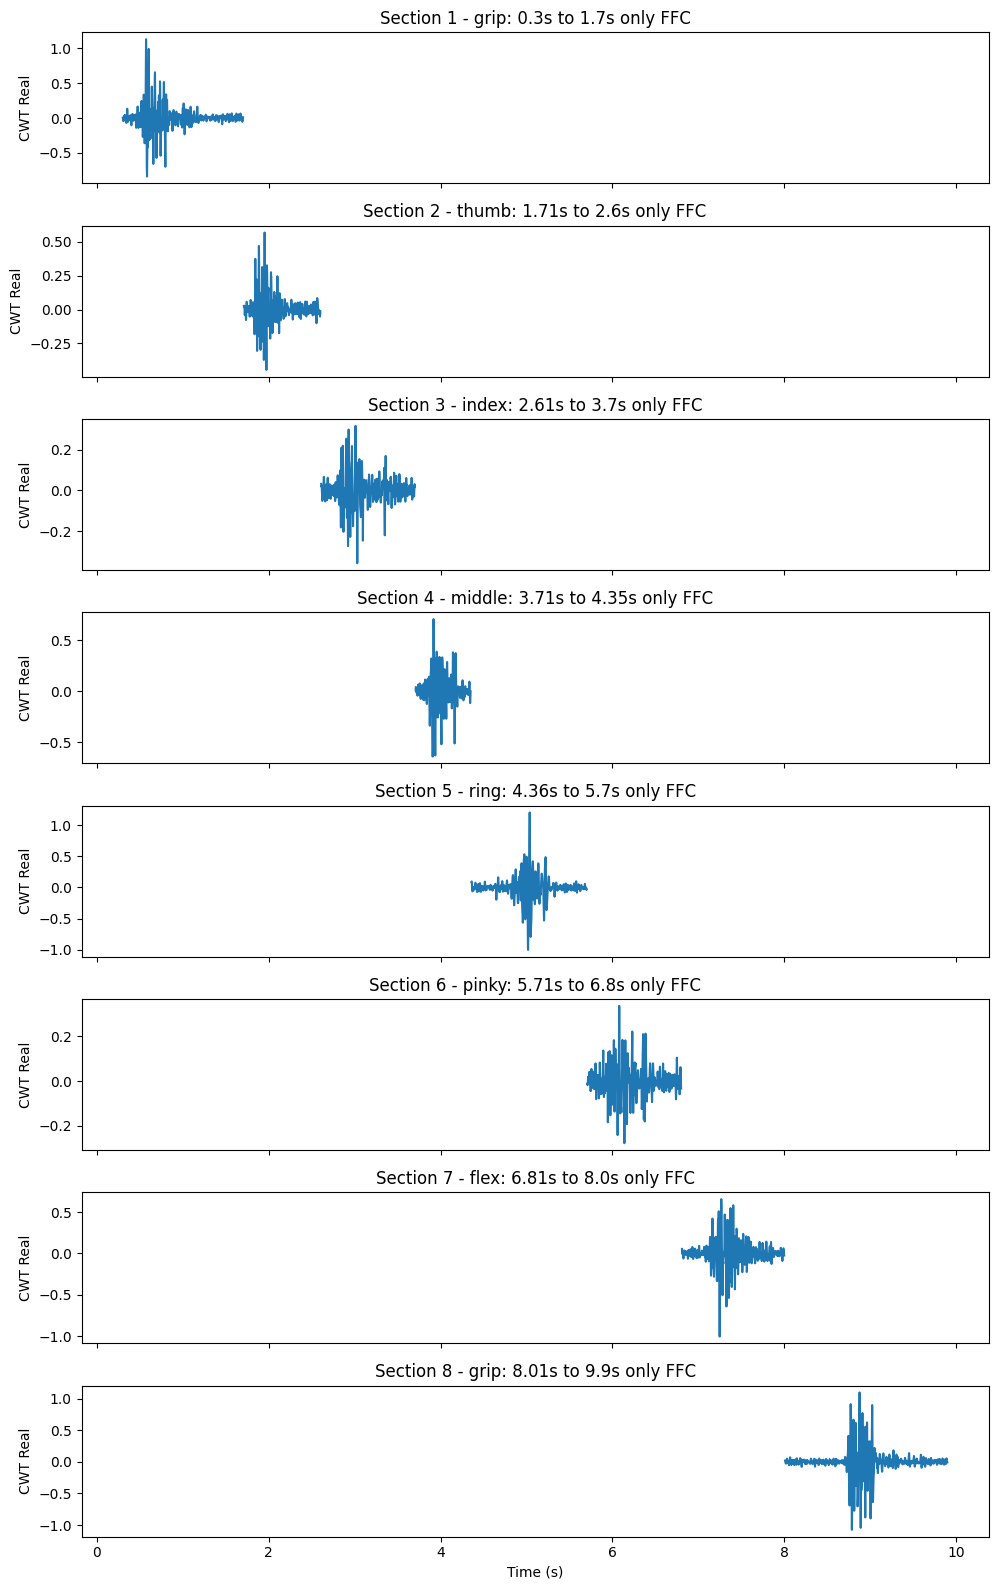

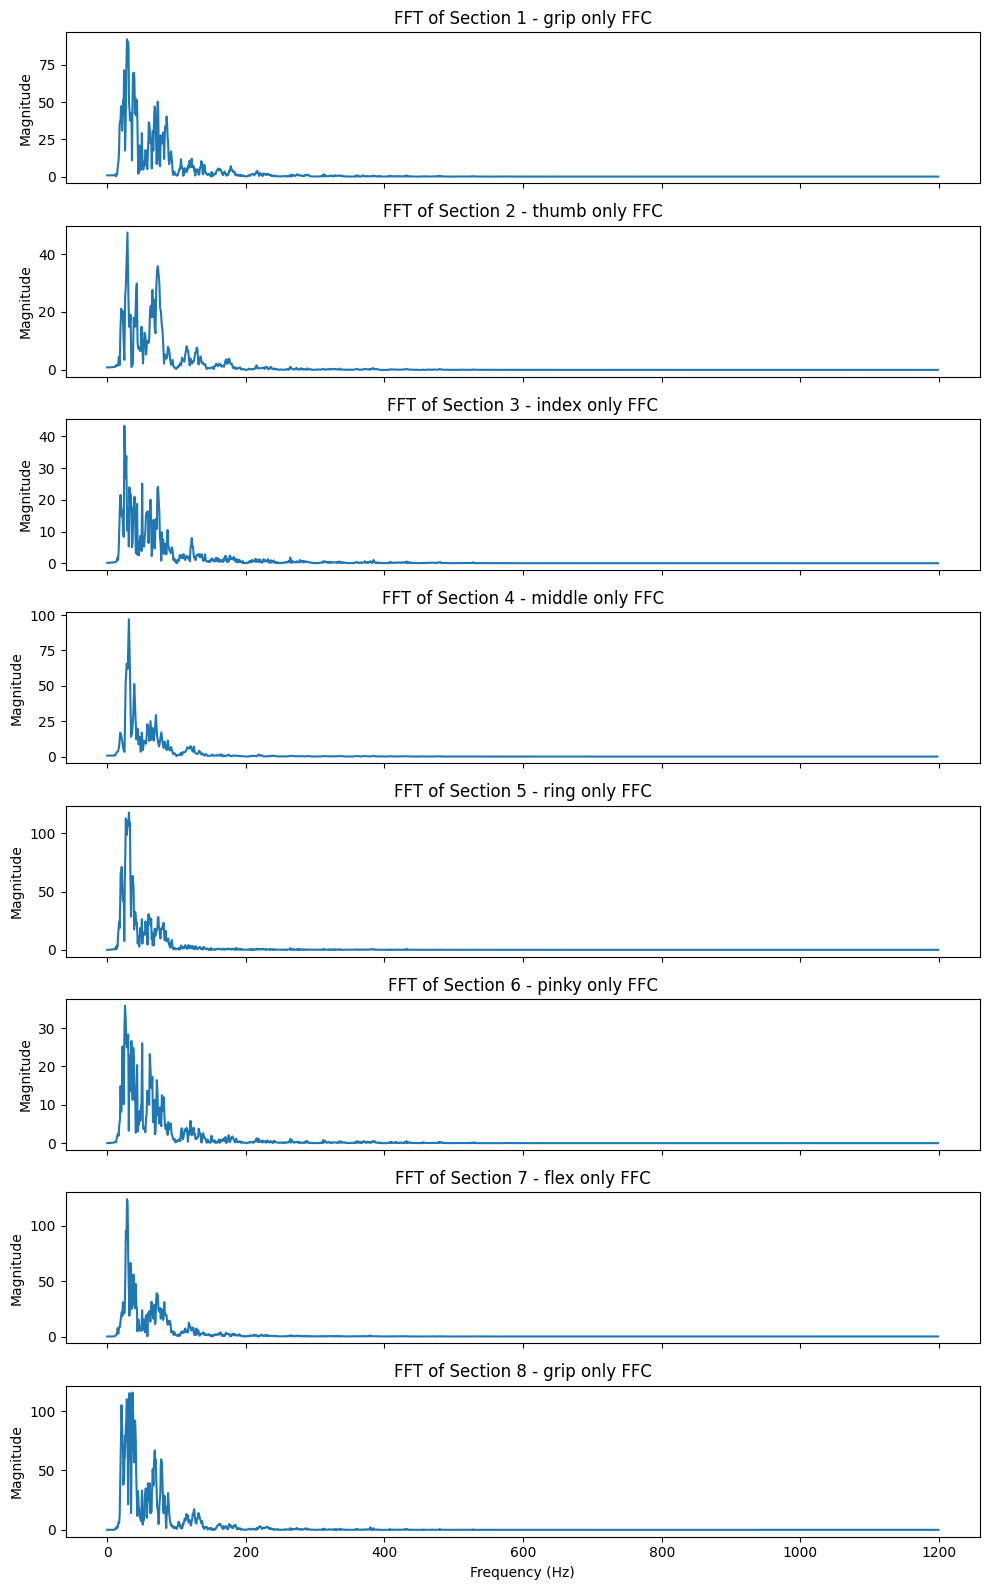

In [19]:
# Cut the real part of CWT into 8 sections based on time intervals and names

sections = [
    (0.3, 1.7),
    (1.71, 2.6),
    (2.61, 3.7),
    (3.71, 4.35),
    (4.36, 5.7),
    (5.71, 6.8),
    (6.81, 8.0),
    (8.01, 9.9)
]
section_names = [
    "grip",
    "thumb",
    "index",
    "middle",
    "ring",
    "pinky",
    "flex",
    "grip"
]

real_cwt = filtered_signal
sectioned_cwt = []

for i, ((start, end), name) in enumerate(zip(sections, section_names), 1):
    mask = (t >= start) & (t <= end)
    sectioned_cwt.append(real_cwt[mask])
    print(f"Section {i} ({name}): {start}s to {end}s, samples: {np.sum(mask)}")

# Example: plot all sections
fig, axs = plt.subplots(8, 1, figsize=(10, 16), sharex=True)
for i, ((start, end), name) in enumerate(zip(sections, section_names)):
    mask = (t >= start) & (t <= end)
    axs[i].plot(t[mask], real_cwt[mask])
    axs[i].set_title(f"Section {i+1} - {name}: {start}s to {end}s only FFC")
    axs[i].set_ylabel("CWT Real")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# FFT for all cut sections of the real part of CWT
section_fft_data = []
section_fft_freqs = []

for i, ((start, end), name) in enumerate(zip(sections, section_names), 1):
    mask = (t >= start) & (t <= end)
    section = real_cwt[mask]
    n = len(section)
    if n > 0:
        fft_signal = np.fft.fft(section)
        fft_freq = np.fft.fftfreq(n, d=1/fs)
        section_fft_data.append(np.abs(fft_signal)[:n//2])
        section_fft_freqs.append(fft_freq[:n//2])
    else:
        section_fft_data.append([])
        section_fft_freqs.append([])

# Plot FFTs for all sections
fig, axs = plt.subplots(8, 1, figsize=(10, 16), sharex=True)
for i, (fft_freq, fft_data) in enumerate(zip(section_fft_freqs, section_fft_data)):
    axs[i].plot(fft_freq, fft_data)
    axs[i].set_title(f"FFT of Section {i+1} - {section_names[i]} only FFC")
    axs[i].set_ylabel("Magnitude")
axs[-1].set_xlabel("Frequency (Hz)")
plt.tight_layout()

In [20]:
# Wvelet parameters
B = 1.5 # Bandwidth
C = 1.0 # Center frequency
wavelet = 'cmor'+ str(B) + '-' + str(C)
print(f"Wavelet: {wavelet}")

#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.arange(6, 500)
# significant_frequencies = np.array([20, 250])

# test = np.array([20, 2000])
# test = test / fs

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# scales = pywt.frequency2scale(wavelet, test)
print(scales)
print(len(scales))

Wavelet: cmor1.5-1.0
width: 16.0
[400.         342.85714286 300.         266.66666667 240.
 218.18181818 200.         184.61538462 171.42857143 160.
 150.         141.17647059 133.33333333 126.31578947 120.
 114.28571429 109.09090909 104.34782609 100.          96.
  92.30769231  88.88888889  85.71428571  82.75862069  80.
  77.41935484  75.          72.72727273  70.58823529  68.57142857
  66.66666667  64.86486486  63.15789474  61.53846154  60.
  58.53658537  57.14285714  55.81395349  54.54545455  53.33333333
  52.17391304  51.06382979  50.          48.97959184  48.
  47.05882353  46.15384615  45.28301887  44.44444444  43.63636364
  42.85714286  42.10526316  41.37931034  40.6779661   40.
  39.3442623   38.70967742  38.0952381   37.5         36.92307692
  36.36363636  35.82089552  35.29411765  34.7826087   34.28571429
  33.8028169   33.33333333  32.87671233  32.43243243  32.
  31.57894737  31.16883117  30.76923077  30.37974684  30.
  29.62962963  29.26829268  28.91566265  28.57142857  28.

Shape of CWT matrix: (494, 23900)
Shape of frequencies: (494,)
Shape of time: (23800,)
Best scale index: 23, Best scale frequency: 28.999999999999996 Hz


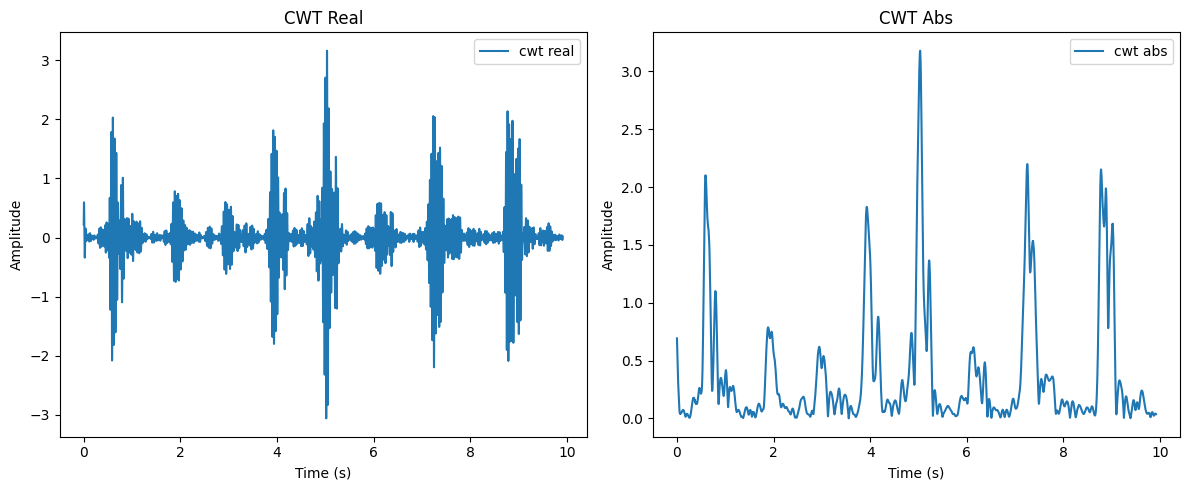

In [21]:
dt = 1/fs
cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

print(f"Shape of CWT matrix: {cwtmatr.shape}")
print(f"Shape of frequencies: {freqs.shape}")
print(f"Shape of time: {t.shape}")

'''
cwtmatr:
-real: filtered signal for the given scales.
-abs: envelope of the filtered signal for the given scales.
'''

mean_abs = np.mean(np.abs(cwtmatr), axis=1)
best_scale_idx = np.argmax(mean_abs)
print(f"Best scale index: {best_scale_idx}, Best scale frequency: {freqs[best_scale_idx]} Hz")

real_cwt = np.real(cwtmatr[best_scale_idx, :])
abs_cwt= np.abs(cwtmatr[best_scale_idx, :])

# real_cwt = real_cwt[1:-1]

# t = t[1:-1]

# Graph of the cwt real and cwt abs side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

real_cwt = real_cwt[100:]  # Drop first 100 samples after filtering
abs_cwt= abs_cwt[100:]  # Drop first 100 samples after filtering

# Plot cwt real
axs[0].plot(t, real_cwt, label='cwt real')
axs[0].set_title("CWT Real")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot cwt abs
axs[1].plot(t, abs_cwt, label='cwt abs')
axs[1].set_title("CWT Abs")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()


plt.tight_layout()
plt.show()

In [22]:
# Cut the real part of CWT into 8 sections based on time intervals and names

sections = [
    (0.3, 1.7),
    (1.71, 2.6),
    (2.61, 3.8),
    (3.81, 4.35),
    (4.36, 5.7),
    (5.71, 6.8),
    (6.81, 8.0),
    (8.01, 9.9)
]
section_names = [
    "grip",
    "thumb",
    "index",
    "middle",
    "ring",
    "pinky",
    "flex",
    "grip"
]

real_cwt = np.real(cwtmatr[best_scale_idx, :])
sectioned_cwt = []

for i, ((start, end), name) in enumerate(zip(sections, section_names), 1):
    mask = (t >= start) & (t <= end)
    sectioned_cwt.append(real_cwt[mask])
    print(f"Section {i} ({name}): {start}s to {end}s, samples: {np.sum(mask)}")

# Example: plot all sections
fig, axs = plt.subplots(8, 1, figsize=(10, 16), sharex=True)
for i, ((start, end), name) in enumerate(zip(sections, section_names)):
    mask = (t >= start) & (t <= end)
    axs[i].plot(t[mask], real_cwt[mask])
    axs[i].set_title(f"Section {i+1} - {name}: {start}s to {end}s")
    axs[i].set_ylabel("CWT Real")
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# FFT for all cut sections of the real part of CWT
section_fft_data = []
section_fft_freqs = []

for i, ((start, end), name) in enumerate(zip(sections, section_names), 1):
    mask = (t >= start) & (t <= end)
    section = real_cwt[mask]
    n = len(section)
    if n > 0:
        fft_signal = np.fft.fft(section)
        fft_freq = np.fft.fftfreq(n, d=1/fs)
        section_fft_data.append(np.abs(fft_signal)[:n//2])
        section_fft_freqs.append(fft_freq[:n//2])
    else:
        section_fft_data.append([])
        section_fft_freqs.append([])

# Plot FFTs for all sections
fig, axs = plt.subplots(8, 1, figsize=(10, 16), sharex=True)
for i, (fft_freq, fft_data) in enumerate(zip(section_fft_freqs, section_fft_data)):
    axs[i].plot(fft_freq, fft_data)
    axs[i].set_title(f"FFT of Section {i+1} - {section_names[i]}")
    axs[i].set_ylabel("Magnitude")
axs[-1].set_xlabel("Frequency (Hz)")
plt.tight_layout()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 23900 but size of corresponding boolean axis is 23800

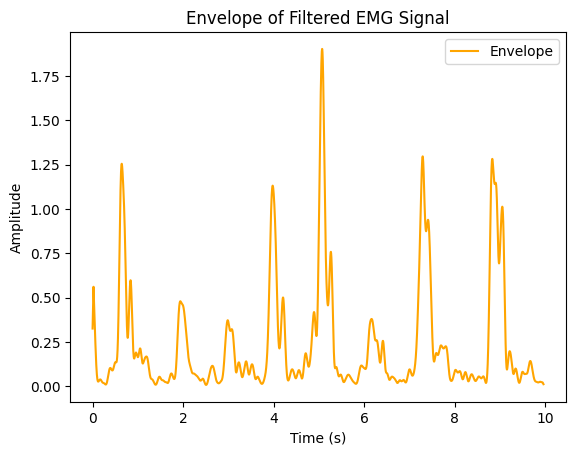

In [ ]:
def linear_envelope(signal, fs, lowpass_cutoff=10.0, window_size=101):
    # Rectify
    rectified = np.abs(signal)
    # Low-pass filter
    nyquist = 0.5 * fs
    norm_cutoff = lowpass_cutoff / nyquist
    b, a = butter(2, norm_cutoff, btype='low')
    filtered = filtfilt(b, a, rectified)
    # Moving average smoothing
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(filtered, window, mode='same')
    return smoothed

envelope = linear_envelope(np.real(cwtmatr[best_scale_idx, :]), fs)

# Plot the envelope

plt.plot(t, envelope, label='Envelope', color='orange')
plt.title("Envelope of Filtered EMG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()     
plt.show()

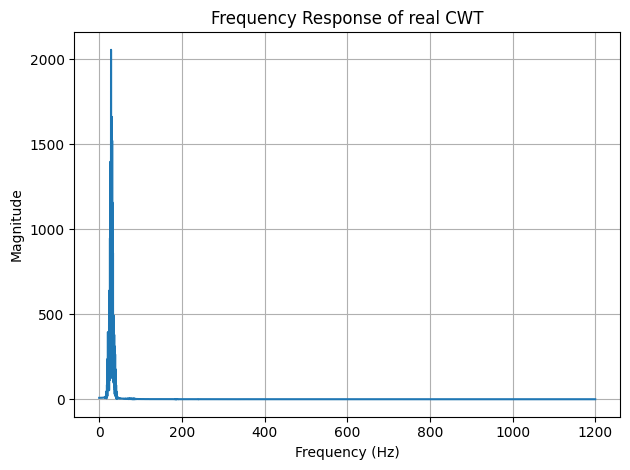

In [ ]:
# fft of the real cwt
n = len(real_cwt)
fft_signal = np.fft.fft(real_cwt)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of real CWT")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Original and Filtered Signal')

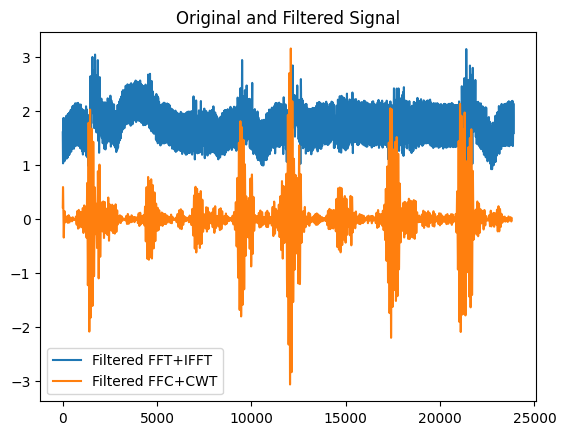

In [ ]:
plt.figure()
plt.plot(adc_values, label='Filtered FFT+IFFT')
plt.plot(real_cwt, label='Filtered FFC+CWT')
plt.legend()
plt.title('Original and Filtered Signal')

In [ ]:
#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.arange(6, 500)

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# print(scales)

width: 16.0


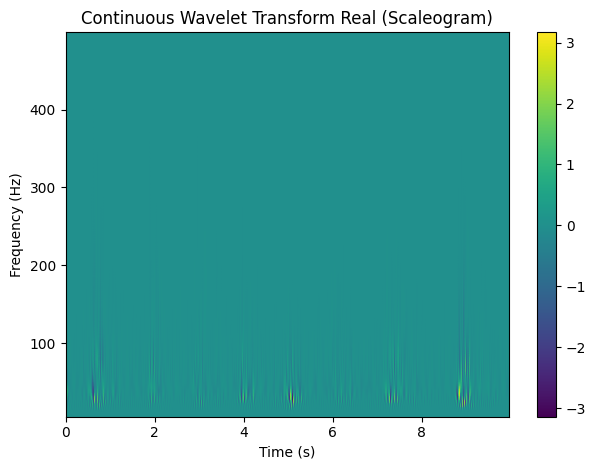

In [ ]:
# Parameters
filename = 'full_movement_range_zginacze.csv'  # Use the full movement range file
sampling_rate = 2400  # in Hz
fs = sampling_rate

# Load ADC values (single column)
adc_values = pd.read_csv(filename, header=None).squeeze()  # Convert to Series

# Drop first 1000 samples
adc_values = adc_values[100:].reset_index(drop=True)
t = np.arange(len(adc_values)) / sampling_rate  # Recompute time axis

cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Plot result using matplotlib's pcolormesh (image with annotated axes)
fig, ax = plt.subplots()
pcm = ax.pcolormesh(t, freqs, np.real(cwtmatr[:-1,:-1]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Continuous Wavelet Transform Real (Scaleogram)")
# ax.set_xlim([10, 15])
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()